In [1]:
#import sys
from pathlib import Path
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Check for project path
PROJECT_PATH = Path('/content/drive/My Drive/vocal_ddsp')
if not PROJECT_PATH.exists():
    raise Exception(f'Project path {PROJECT_PATH} does not exist')
  
# Check if separated data exists
TRAINING_DATASET_PATH = f"{str(PROJECT_PATH)}/training_data"
if not Path(TRAINING_DATASET_PATH).exists():
    raise Exception(f"Training dataset path not found at '{TRAINING_DATASET_PATH}'") 

# Check for checkpoints path
CHECKPOINTS_PATH = f"{str(PROJECT_PATH)}/checkpoints"
if not Path(CHECKPOINTS_PATH).exists():
  os.mkdir(CHECKPOINTS_PATH)
  assert Path(CHECKPOINTS_PATH).exists()

# Check for gins path
GINS_PATH = f"{str(PROJECT_PATH)}/gins"
if not Path(GINS_PATH).exists():
    raise Exception(f"Gins path not found at '{GINS_PATH}'") 

# Import DDSP to collab
%tensorflow_version 2.x
%pip install -qU ddsp
%pip install apache-beam
%pip install python-snappy

import warnings
import copy
import os
import time
import glob
import gin
import librosa
import pickle
import crepe
import ddsp
import ddsp.training

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import ipywidgets as widgets

from ddsp.colab import colab_utils
from ddsp.training import postprocessing
from google.colab import files
from ipywidgets import interact
from IPython.display import Javascript

%config InlineBackend.figure_format='retina'

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
     |████████████████████████████████| 209 kB 15.8 MB/s 
     |████████████████████████████████| 1.1 MB 58.3 MB/s 
     |████████████████████████████████| 3.6 MB 57.3 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 90 kB 12.3 MB/s 
     |████████████████████████████████| 1.1 MB 49.7 MB/s 
     |████████████████████████████████| 210 kB 71.1 MB/s 
     |████████████████████████████████| 129 kB 71.7 MB/s 
     |████████████████████████████████| 20.2 MB 1.1 MB/s 
     |████████████████████████████████| 5.6 MB 33.5 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 
     |████████████████████████████████| 462 kB 61.9 MB/s 
     |████████████████████████████████| 213 kB 65.5 MB/s 
     |████████████████████████████████| 10.1 MB 16.3 MB/s 
     |████████████████████████████████| 508 kB 62.3 MB/s 
     |████████████████████████████████| 253 kB 66.5 MB/s 
     |████████████████████████████████| 46 kB 3.7 

     |████████████████████████████████| 56 kB 4.2 MB/s 
Tue Apr 19 12:09:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

In [2]:
import random


class TrainedModel:
  """Loads a trained model and its original dataset and provides a series of
  helper functions to evaluate and process its data"""

  def __init__(self, dataset_relative_path, model_relative_path = None):
    if model_relative_path is None:
      model_relative_path = dataset_relative_path

    # Check for dataset path existance
    dataset_path = f"{TRAINING_DATASET_PATH}/{dataset_relative_path}"
    if not Path(dataset_path).exists():
      raise Exception(f"Failed to load model instance, dataset_relative_path {self.dataset_path} does not exist")
    
    self.dataset_pattern = f"{dataset_path}/*"

    # Check for model path existance
    self.model_path = f"{CHECKPOINTS_PATH}/{model_relative_path}"
    if not Path(self.model_path).exists():
      raise Exception(f"Failed to load model instance, model_relative_path {self.model_path} does not exist")

    self.data_provider = ddsp.training.data.TFRecordProvider(self.dataset_pattern)
    
    # Gin config file
    self.gin_file = os.path.join(self.model_path, 'operative_config-0.gin')
    with gin.unlock_config():
      gin.parse_config_file(self.gin_file, skip_unknown=True)
    
    # See if any stats were saved
    dataset_stats_file = os.path.join(self.model_path, 'dataset_statistics.pkl')

    try:
      if tf.io.gfile.exists(dataset_stats_file):
        with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
          self.DATASET_STATS = pickle.load(f)
      else:
          print('WARNING: pickle file not present')
          self.DATASET_STATS = None
    except Exception as err:
      # Don't throw Exception here
      print('Loading dataset statistics from pickle failed: {}.'.format(err))
      self.DATASET_STATS = None
    
    # Load the model
    self.model = ddsp.training.models.Autoencoder()
    self.model.restore(self.model_path)
  
  @property
  def dataset_length(self):
    return len(list(self.get_training_dataset()))
  
  def get_training_dataset(self, shuffle=False):
    return self.data_provider.get_dataset(shuffle=shuffle)
  
  def generate_audio_from_batch(self, batch):
    """Infers audio based off of a batch"""
    outputs = self.model(batch, training=False)
    return self.model.get_audio_from_outputs(outputs)
  
  def get_frame(self, shuffle_batching=True):
    batch = self.data_provider.get_batch(batch_size=1, shuffle=shuffle_batching)
    # Get a 4 second frame someway though the randomised dataset
    target_length = int(random.randint(0, self.dataset_length) / 2)
    for i, frame in enumerate(iter(batch)):
      if i == target_length:
        return frame
    
  




In [3]:
def shift_f0(audio_features, pitch_shift=0.0):
    """Shift f0 by a number of octaves."""
    audio_features['f0_hz'] *= 2.0 ** (pitch_shift)

    # This limits f0 range to 0 to the 110th midi note frequency
    #audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
    #                                0.0, 
    #                                librosa.midi_to_hz(110.0))
    
    return audio_features

def pitch_inference_test(audio, octave_levels):
  """
  Caries out a pitch inference test on an audio sample at varous octave levels
  and plots the results
  """

  # Setup the session and get training sample audio features
  ddsp.spectral_ops.reset_crepe()
  audio_features = ddsp.training.metrics.compute_audio_features(audio)
  audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)

  print("Training Dataset Frame")
  ddsp.colab.colab_utils.play(audio)
  ddsp.colab.colab_utils.specplot(audio)
  plt.title("Training Dataset Frame Spectrogram")

  modified_audio_features = []
  octave_names = []

  for level in octave_levels:
    audio_features_mod = None
    audio_features_mod = {k: tf.convert_to_tensor(v) for k, v in audio_features.items()}
    audio_features_mod = shift_f0(audio_features_mod, level)
    modified_audio_features.append(audio_features_mod)

    # Infer new model outputs from the trained model and using the modified audio features
    outputs = trained_model.model(audio_features_mod, training=False)
    inferred_audio = trained_model.model.get_audio_from_outputs(outputs)

    level_signed = f"+{level}" if level > 0 else level
    ocatave_name = f"Octave {level_signed}"

    level_name = f"Inferred Frame for the {level_signed} Octave"
    octave_names.append(ocatave_name)

    print(level_name)
    ddsp.colab.colab_utils.play(inferred_audio)
    ddsp.colab.colab_utils.specplot(inferred_audio)
    plt.title(f"{level_name} Spectrogram")
  
  # Plot modified_audio_features
  fig, axes = plt.subplots(nrows=2, 
                      ncols=1, 
                      sharex=True,
                      figsize=(8, 16))

  loudness_ax = axes[0]
  f0_ax = axes[1]
  loudness_ax.plot(audio_features['loudness_db'])
  f0_ax.plot(audio_features['f0_hz'])

  labels = ['Original']
  labels += octave_names

  for modified_feature in modified_audio_features:
    loudness_ax.plot(modified_feature['loudness_db'])
    f0_ax.plot(modified_feature['f0_hz'])

  loudness_ax.set_ylabel('loudness_db')
  loudness_ax.set_xlabel('Timesteps')
  loudness_ax.title.set_text("Loudness Latent Representation")
  f0_ax.set_ylabel('f0_hz')
  f0_ax.set_xlabel('Timesteps')
  f0_ax.title.set_text("Fudamental Frequency Latent Representation")

  loudness_ax.legend(labels)
  f0_ax.legend(labels)


In [4]:
def get_upload_audio():
  filenames, audios = ddsp.colab.colab_utils.upload()
  audio = audios[0]

  if len(audio.shape) == 1:
    audio = audio[np.newaxis, :]
  
  return audio

In [5]:
# Needs to be enabled, disable tensorflow warnings
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tf.get_logger().setLevel('ERROR')

Saving ctrimmed1.mp3 to ctrimmed1.mp3


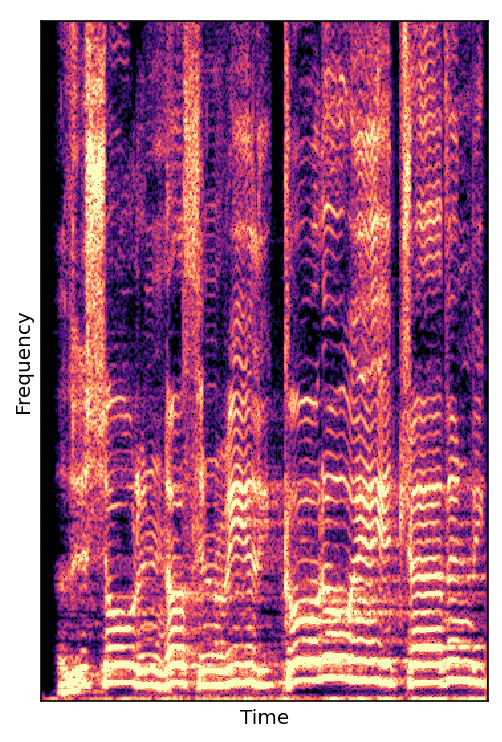

In [6]:
#trained_model = TrainedModel("TaylorSwiftSelected", "TaylorSwiftSelected_h100_n60")
trained_model = TrainedModel("ColdplaySelected", "ColdplaySelected_h100_n60")

# Get a sample frame from the training dataset
#frame = trained_model.get_frame(shuffle_batching=False)
# Get audio sample of the frame
#training_audio = frame['audio']

# Or upload an audio sample
training_audio = get_upload_audio()

ddsp.colab.colab_utils.play(training_audio)
ddsp.colab.colab_utils.specplot(training_audio)

## Resynthesis of original frame
No modification of latents

In [ ]:
audio_features = ddsp.training.metrics.compute_audio_features(training_audio)
example = audio_features

# Original
training_audio = example['audio']
ddsp.colab.colab_utils.play(training_audio)
ddsp.colab.colab_utils.specplot(training_audio)
plt.title("Training Dataset Frame Spectrogram")

# Inference
outputs = trained_model.model(example, training=False)
inferred_audio = trained_model.model.get_audio_from_outputs(outputs)
ddsp.colab.colab_utils.play(inferred_audio)
ddsp.colab.colab_utils.specplot(inferred_audio)
plt.title("Inferred Frame Spectrogram")

In [ ]:
pitch_levels = [-2, -1, 0, 0.5, 1, 2]

pitch_inference_test(training_audio, pitch_levels)

## Constant pitch test
This test fixes the pitch component at a fixed value

In [12]:
def set_monopitch(audio_features, pitch=10000000):
  """Sets the whole sample F0 pitch as constant, if none mean is found"""

  if pitch is None:
    pitch = np.mean(audio_features['f0_hz'])
  
  shape = tf.shape(audio_features['f0_hz'])
  audio_features['f0_hz'] = tf.fill(shape, pitch)

  return audio_features, pitch

def set_sinusoidal(audio_features):
  """Sets a sinusoidal pitch just for fun"""

  timesteps = np.linspace(0, 4, 1000)
  sinusoidals = tf.convert_to_tensor(100*np.sin(timesteps*5)+200)

  shape = tf.shape(audio_features['f0_hz'])
  audio_features['f0_hz'] = sinusoidals

  return audio_features, 0
  
  
def monopitch_inference_test(audio, pitch=None):
  """
  Performs a monopitch inference test using given pitch,
  if None then mean is used
  """

  # Setup the session and get training sample audio features
  ddsp.spectral_ops.reset_crepe()
  audio_features = ddsp.training.metrics.compute_audio_features(audio)
  audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)

  print("Training Dataset Frame")
  ddsp.colab.colab_utils.play(audio)
  ddsp.colab.colab_utils.specplot(audio)
  plt.title("Training Dataset Frame Spectrogram")

  audio_features_mod = {k: tf.convert_to_tensor(v) for k, v in audio_features.items()}
  audio_features_mod, actual_pitch = set_monopitch(audio_features_mod, pitch)
  #audio_features_mod, actual_pitch = set_sinusoidal(audio_features_mod)

  # Infer new model outputs from the trained model and using the modified audio features
  outputs = trained_model.model(audio_features_mod, training=False)
  inferred_audio = trained_model.model.get_audio_from_outputs(outputs)
  pitch_name = f"Fixed F0 {actual_pitch:.2f} Hz"
  level_name = f"Inferred Frame for {pitch_name}"

  print(level_name)
  ddsp.colab.colab_utils.play(inferred_audio)
  ddsp.colab.colab_utils.specplot(inferred_audio)
  plt.title(f"{level_name} Spectrogram")

  # Plot modified_audio_features
  fig, axes = plt.subplots(nrows=2, 
                      ncols=1, 
                      sharex=True,
                      figsize=(8, 16))

  loudness_ax = axes[0]
  f0_ax = axes[1]

  loudness_ax.plot(audio_features['loudness_db'].astype(np.float32))
  f0_ax.plot(audio_features['f0_hz'].astype(np.float32))

  labels = ['Original', pitch_name]

  loudness_ax.plot(audio_features_mod['loudness_db'])
  f0_ax.plot(audio_features_mod['f0_hz'])

  loudness_ax.set_ylabel('loudness_db')
  loudness_ax.set_xlabel('Timesteps')
  f0_ax.set_ylabel('f0_hz')
  f0_ax.set_xlabel('Timesteps')

  loudness_ax.legend(labels)
  f0_ax.legend(labels)

In [ ]:
monopitch_inference_test(training_audio, 500)

## Amplitude variation test

Amplitude is varied from -10dB at the start of the sample to +10dB at the end to determine the effect of changing the amplitude latent information.

In [ ]:
def set_loudness_log_linear(audio_features):
  """Sets loudness latent encoding to log linear"""

  timesteps = np.linspace(0, 4, 1000)
  #loudness = tf.convert_to_tensor(5 * timesteps - 100)
  loudness = tf.convert_to_tensor(0 * timesteps - 1000)

  shape = tf.shape(audio_features['loudness_db'])
  audio_features['loudness_db'] = loudness

  return audio_features

def log_linear_loudness_inference_test(audio):
  """
  Log linear inference test
  """

  # Setup the session and get training sample audio features
  ddsp.spectral_ops.reset_crepe()
  audio_features = ddsp.training.metrics.compute_audio_features(audio)
  audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)

  print("Training Dataset Frame")
  ddsp.colab.colab_utils.play(audio)
  ddsp.colab.colab_utils.specplot(audio)
  plt.title("Training Dataset Frame Spectrogram")

  audio_features_mod = {k: tf.convert_to_tensor(v) for k, v in audio_features.items()}
  audio_features_mod = set_loudness_log_linear(audio_features_mod)

  # Infer new model outputs from the trained model and using the modified audio features
  outputs = trained_model.model(audio_features_mod, training=False)
  inferred_audio = trained_model.model.get_audio_from_outputs(outputs)
  level_name = f"Inferred Frame for Log Linear Loudness"

  print(level_name)
  ddsp.colab.colab_utils.play(inferred_audio)
  ddsp.colab.colab_utils.specplot(inferred_audio)
  plt.title(f"{level_name} Spectrogram")

  # Plot modified_audio_features
  fig, axes = plt.subplots(nrows=2, 
                      ncols=1, 
                      sharex=True,
                      figsize=(8, 16))

  loudness_ax = axes[0]
  f0_ax = axes[1]

  loudness_ax.plot(audio_features['loudness_db'].astype(np.float32))
  f0_ax.plot(audio_features['f0_hz'].astype(np.float32))

  labels = ['Original', 'Log Linear Loudness']

  loudness_ax.plot(audio_features_mod['loudness_db'])
  f0_ax.plot(audio_features_mod['f0_hz'])

  loudness_ax.set_ylabel('loudness_db')
  loudness_ax.set_xlabel('Timesteps')
  f0_ax.set_ylabel('f0_hz')
  f0_ax.set_xlabel('Timesteps')

  loudness_ax.legend(labels)
  f0_ax.legend(labels)

In [ ]:
log_linear_loudness_inference_test(training_audio)

## Timbre transfer test

Another artists song is put through the model to see if the original artist's timbre can be applied to the new song successfully

Saving original_frame.wav to original_frame.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/usr/local/lib/python3.7/dist-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


Resynthesis


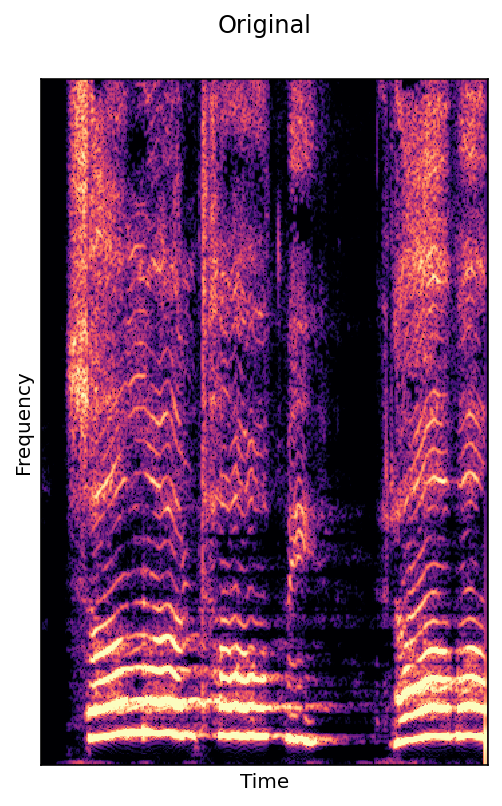

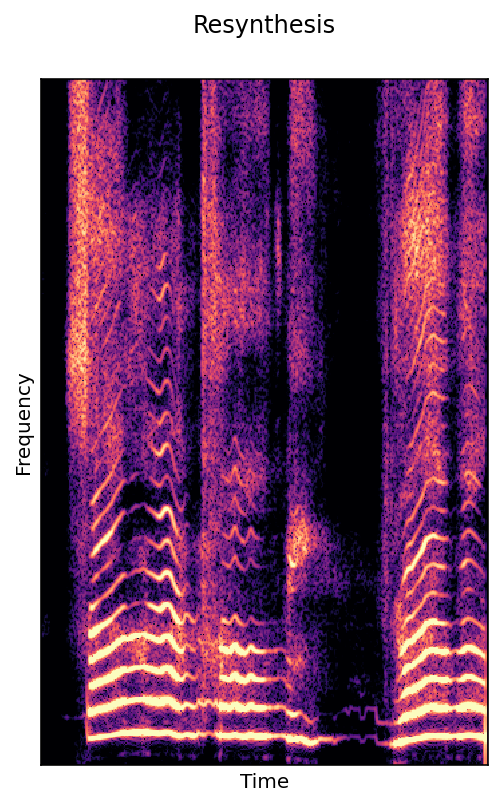

In [20]:
unseen_track = get_upload_audio()

unseen_audio_features = ddsp.training.metrics.compute_audio_features(unseen_track)

outputs = trained_model.model(unseen_audio_features, training=False)
audio_gen = trained_model.model.get_audio_from_outputs(outputs)

ddsp.colab.colab_utils.play(unseen_track)

print('Resynthesis')
ddsp.colab.colab_utils.play(audio_gen)

ddsp.colab.colab_utils.specplot(unseen_track)
plt.title("Original")

ddsp.colab.colab_utils.specplot(audio_gen)
_ = plt.title("Resynthesis")

/usr/local/lib/python3.7/dist-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


Training Dataset Frame


/usr/local/lib/python3.7/dist-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


Inferred Frame for Fixed F0 380.01 Hz


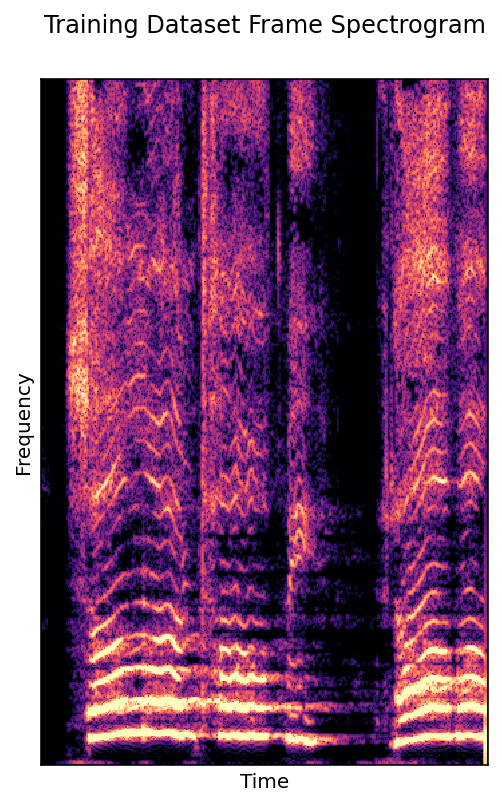

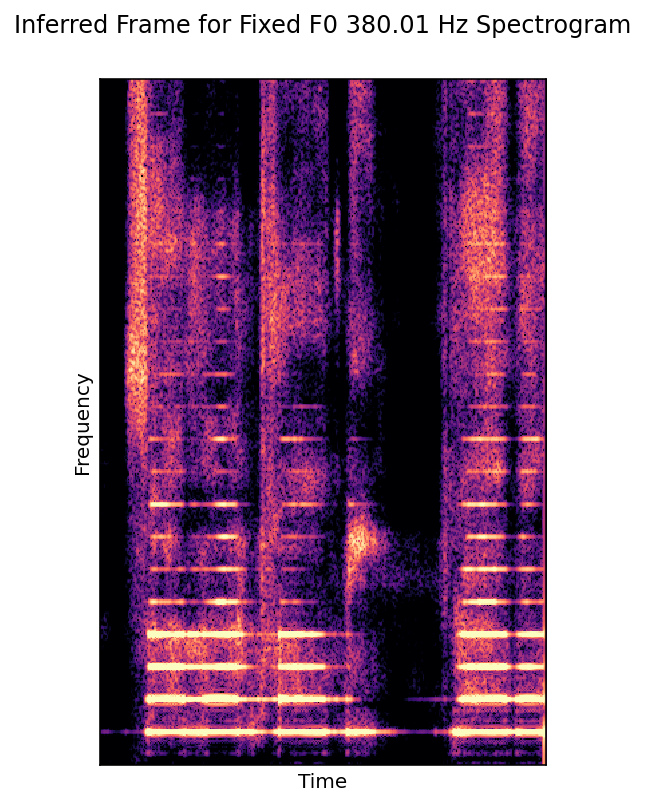

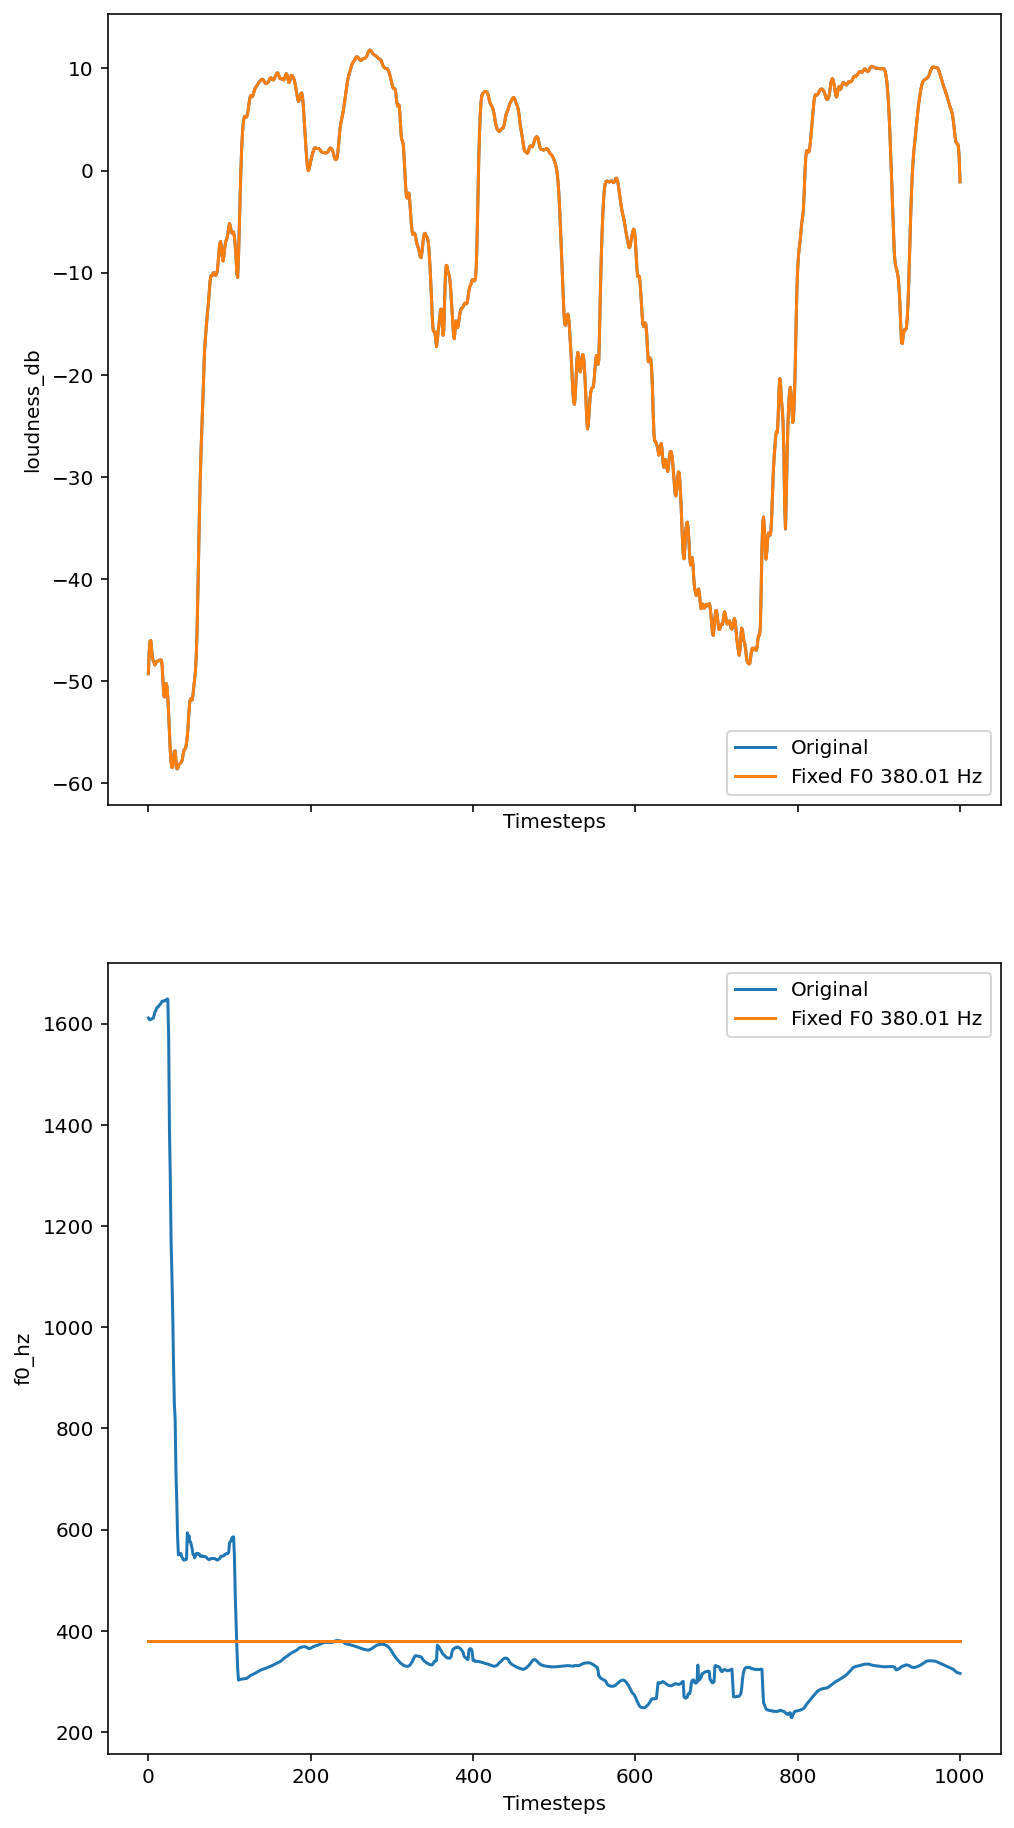

In [22]:
monopitch_inference_test(unseen_track)